# Data Pre-Processing

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets

/content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets


In [ ]:
train_directory = '/content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets/train' # load pre-devided train image file (path to train file)
test_directory = '/content/drive/MyDrive/Colab Notebooks/SolarPanel_Datasets/test' # load pre-devided test image file (path to test file)

# Create training and validation datasets from the train directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,  # Randomize the order of images to prevent the model from learning any unintended order-based patterns
    seed=2024,  # Ensure reproducibility by setting a seed for the randomization process
    validation_split=0.2,  # Use 20% for validation
    subset='training'  # Specify that this is the training subset
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,  # Randomize the order of images to prevent the model from learning any unintended order-based patterns
    seed=2024,  # Ensure reproducibility by setting a seed for the randomization process
    validation_split=0.2,  # Use 20% for validation
    subset='validation'  # Specify that this is the validation subset
)

# Create the testing dataset from the test directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,  # Randomize the order of images to prevent the model from learning any unintended order-based patterns
    seed=2024  # Ensure reproducibility by setting a seed for the randomization process
)

Found 706 files belonging to 6 classes.
Using 565 files for training.
Found 706 files belonging to 6 classes.
Using 141 files for validation.
Found 179 files belonging to 6 classes.


In [ ]:
lables=train_dataset.class_names
lables

['Bird-drop',
 'Clean',
 'Dusty',
 'Electrical-damage',
 'Physical-Damage',
 'Snow-Covered']

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,15))

num_samples_to_display = 15
for images, labels in train_dataset.take(1):  # Take one batch from the training dataset (32 images per batch)
    for i in range(num_samples_to_display): # Iterate through the first 15 images and labels in the batch
        image = images[i].numpy().astype("uint8") # Convert tensor representing the image into a NumPy array (ensure the data type matches that are required for image display)
        label = labels[i]

        # Create a subplot
        plt.subplot(3, 5, i + 1) # i+1 ensure that each image occupies the correct subplot position
        plt.imshow(image) # Display current image in its subplot
        plt.title(f'Label: {labels[label]}') # Set title for the subplot (title is the label of the image)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# MobileNetV3(Large) Training

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

In [22]:
input_tensor = Input(shape=(224, 224, 3))
input = tf.keras.applications.mobilenet_v3.preprocess_input(input_tensor) #
base_model = MobileNetV3Large(input_tensor=input, include_top=False, weights='imagenet') # Exclude the top part (fully connected layers) of the model / Load pre-trained weights from the ImageNet dataset, which provides a strong foundation for feature extraction
for layer in base_model.layers:
    layer.trainable=False # Freeze the weights of the base model, preventing them from being updated during training.

In [23]:
base_model_output=base_model.output

In [24]:
x = base_model.output # Access the output tensor of the pre-trained MobileNet_V3 which serves as the input to the custom layers added next
x = tf.keras.layers.GlobalAveragePooling2D()(x) # add GAP layer to the model
x = tf.keras.layers.Dropout(0.5)(x) # add dropout (50%) layer to the model
output = Dense(6,activation='softmax')(x) # add fully connected layer for final output (6 output node for calssification & softmax activation function)
model = tf.keras.Model(inputs=input, outputs=output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation_20[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu_19[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation_20[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 3,002,118 (11.45 MB)

 Trainable params: 5,766 (22.52 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [25]:
model

<Functional name=functional_1, built=True>

In [26]:
tf.random.set_seed(2024) # Ensuring that the model's weight initialization, data shuffling, and other random processes yield the same results every time the code runs

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), # Adam optimizer with a learning rate of 0.001
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss function is Sparse Categorical Crossentropy / Output is logits not probability
              metrics=['accuracy'] # Evaluation metric is accuracy
              )

# Training the model
epoch = 15
history=model.fit(train_dataset, validation_data=validation_dataset, epochs=epoch, # Trains the model on the train_dataset and evaluates the performance with test_dataset after each epoch
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2, # Minimum improvement in validation loss required to continue training
            patience=3, # Training stops if validation loss does not improve for 3 consecutive epochs
            verbose=1, # Displays detailed messages about early stopping
            restore_best_weights=True # Restores the model weights from the epoch with the best validation loss after training stops
        )
    ]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2172 - loss: 2.7861 - val_accuracy: 0.4043 - val_loss: 1.6283
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 489ms/step - accuracy: 0.3678 - loss: 1.8572 - val_accuracy: 0.5674 - val_loss: 1.2220
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - accuracy: 0.5069 - loss: 1.4209 - val_accuracy: 0.6738 - val_loss: 1.0443
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 489ms/step - accuracy: 0.6034 - loss: 1.1113 - val_accuracy: 0.6809 - val_loss: 0.9813
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - accuracy: 0.6635 - loss: 0.9024 - val_accuracy: 0.7021 - val_loss: 0.9164
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.7136 - loss: 0.7847 - val_accuracy: 0.7092 - val_loss: 0.8893
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.7212 - loss: 0.8171 - val_accuracy: 0.7234 - val_loss: 0.8591
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 445ms/step - accuracy: 0.7461 - loss: 0.6562 - val_accuracy: 0.7447 - va

# MobileNetV3(Large) Testing

In [27]:
test_dataset.class_names

['Bird-drop',
 'Clean',
 'Dusty',
 'Electrical-damage',
 'Physical-Damage',
 'Snow-Covered']

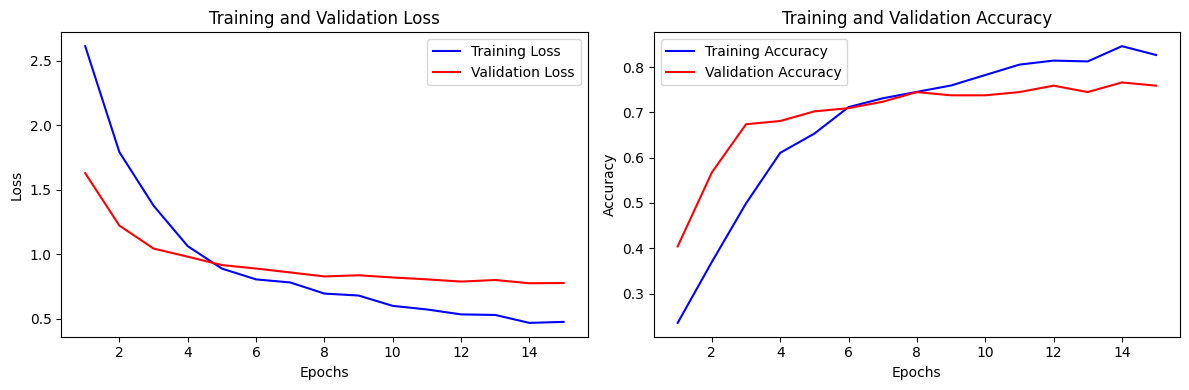

In [28]:
# Extract training and validation metrics stored in the history object, which is the result of model.fit()
# Value for each epoch
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create x-axis values (epochs)
epochs = range(1, len(training_loss) + 1) # len(training_loss) = total number of epochs -> Starts at epoch 1 (not 0) and ends at the total number of epochs

# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
# Evaluating with test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss: 2f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 617ms/step - accuracy: 0.7766 - loss: 0.6567
Test Accuracy: 75.42%
Test Loss:  0.678521


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8264 - loss: 0.4448
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━

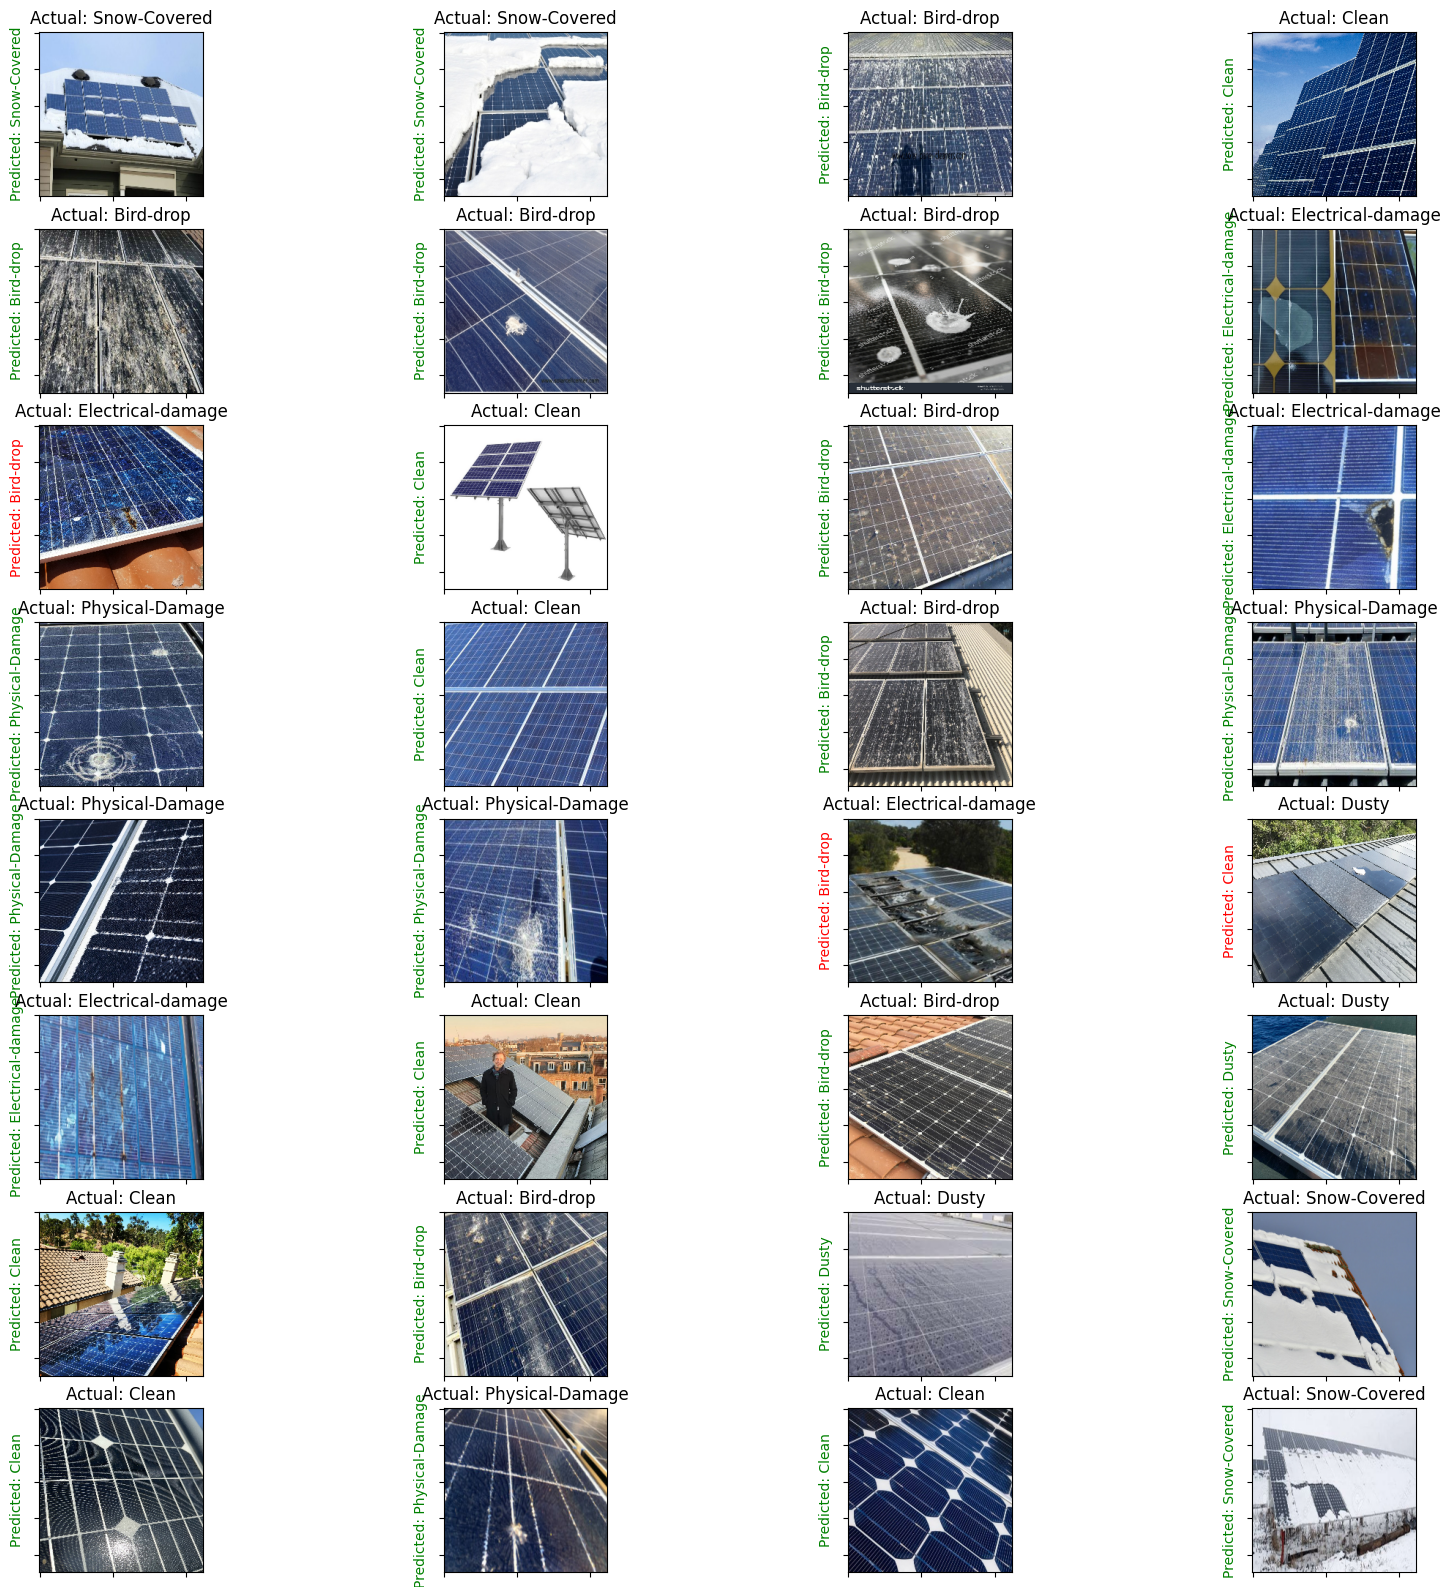

In [ ]:
loss, accuracy = model.evaluate(test_dataset) # Evaluate the model's performance on the test_dataset returning loss and accuracy
class_names = train_dataset.class_names # Retrieve the list of class names from the training dataset (each class corresponds to a subfolder in the dataset directory)
plt.figure(figsize=(20, 20))
for images, labels in test_dataset.take(1): # Retrieve 1 batch of images and their corresponding labels from the test_dataset
    for i in range(32): # Iterate through the first 32 images in the batch (batch size==32)
        ax = plt.subplot(8, 4, i + 1) # Create a grid of subplots with 8 rows and 4 columns (Position the current image in the correct slot)
        plt.imshow(images[i].numpy().astype("uint8")) # Display the i-th image from the batch after converting it from a TensorFlow tensor to a NumPy array, and ensure it is in the correct format (uint8)
        predictions = model.predict(tf.expand_dims(images[i], 0)) # Add an extra dimension to the image tensor to make it compatible with the model's input shape / Predict the probability for each class for the i-th image
        score = tf.nn.softmax(predictions[0]) # Apply softmax function
        if(class_names[labels[i]]==class_names[np.argmax(score)]): # Compare the true class with the predicted class / labels[i]=true label / np.argmax(score)=index of the class with the highest probability (predicted class)
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'}) # if correct prediction

        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'}) # if incorrect prediction

        plt.gca().axes.yaxis.set_ticklabels([]) # Remove tick labels on x-axis for the subplot to make the visualization cleaner
        plt.gca().axes.xaxis.set_ticklabels([]) # Removes tick labels on y-axis for the subplot to make the visualization cleaner
        plt.show()